<div style="border:solid steelblue 3px; padding: 20px; border-radius: 10px">

**Привет, Ирина!** 👋

Меня зовут Алексей Манелюк, я буду проверять твой проект. В Яндекс Практикуме принято общаться на "ты" 😉, но если некомфортно - скажи и перейдем на "Вы".

Моя цель - не указать на ошибки, а поделиться опытом и помочь в освоении анализа данных.

В тетрадке ты увидишь мои комментарии, пожалуйста, не удаляй, не перемещай и не изменяй их. У комментариев могут быть приписки **V2**, **V3**, **V...**, которые соответствуют каждой версии проверки. 
    
Я буду использовать цветовую разметку:
<p>
<div class="alert-danger" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ❌</b>

Так выделены критические замечания. Без их отработки я не смогу принять проект. </div>

<div class="alert-warning" style="padding: 20px; border-radius: 10px">
<b>  Комментарий ревьюера ⚠️</b>

Так выделены небольшие замечания или полезные советы. Постарайся учесть их.</div>
<p>
<div class="alert-success" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ✔️</b>

Так выделены правильные решения.</div>

Предлагаю работать в диалоге: если что-то дорабатываешь или отвечаешь на мой комментарий - пиши об этом. Мне будет удобней, если ты выделишь свои комментарии:
<p>
<div class="alert-info" style="padding: 20px; border-radius: 10px">
<b>Комментарий студента 💎</b>

Здесь исправил.</div>

Все это поможет мне быстрее принять твой проект.</div>

<div class="alert-info" style="padding: 20px; border-radius: 10px">
<b>Комментарий студента 💎</b>

Написать свой комментарий можно, скопировав этот блок в ячейку Markdown.</div>

# Исследование данных о российском кинопрокате



В данном проекте я исследую данные из двух истоников - статистика по фильмам из Кинопоиска и данные о сборах и финансовой поддержке от Министерства Культуры. 

В процессе выполнения проекта, я объединю данные из двух источников. Затем я обработаю данные - по возможности устраню пропуски и дубликаты. Далее я посмотрю на динамику проката и сборов от фильмов по годам. В заключительной части я исследую как финансовая поддержка влияет на сборы и рейтинг фильмов. 

<div class="alert-success" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ✔️</b>

Отлично, что начала с описания проекта. 👍
</div>

# Шаг 1. Откройте файлы с данными и объедините их в один датафрейм. 

Объедините данные таким образом, чтобы все объекты из датасета `mkrf_movies` обязательно вошли в получившийся датафрейм. 

<div id="accordion">
    <div class="card">
        <div class="card-header" id="headingThree">
            <button class="btn btn-link collapsed" data-toggle="collapse" data-target="#collapseHint_0" aria-expanded="false" aria-controls="collapseHint_0">Подсказка</button>
        </div>
        <div id="collapseHint_0" class="collapse" aria-labelledby="headingThree" data-parent="#accordion">
            <div class="card-body">
Обратите внимание на тип данных столбца, по которому будете соединять датафреймы. Тип данных этих столбцов должен быть одинаковым в обоих датафреймах.
            </div>
        </div>
    </div>
</div>

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import statsmodels.api as sm
import math
import seaborn as sns

In [2]:
# Загрузим данные
data_movies= pd.read_csv('/datasets/mkrf_movies.csv')
data_shows = pd.read_csv('/datasets/mkrf_shows.csv')

Выведем таблицы, чтобы посмореть на переменные.

In [3]:
# вывод
display(data_movies.head(5))
data_shows.head(5)

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
0,Открытый простор,221048915,2015-11-27T12:00:00.000Z,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.2,"боевик,драма,мелодрама"
1,Особо важное задание,111013716,2016-09-13T12:00:00.000Z,Художественный,"Киностудия ""Мосфильм""",СССР,Е.Матвеев,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.6,"драма,военный"
2,Особо опасен,221038416,2016-10-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер"
3,Особо опасен,221026916,2016-06-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер"
4,Особо опасен,221030815,2015-07-29T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер"


,puNumber,box_office
0,111000113,2.450000e+03
1,111000115,6.104000e+04
2,111000116,1.530300e+08
3,111000117,1.226096e+07
4,111000118,1.636841e+08


<div class="alert-warning" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ⚠️</b>

📌 Для более наглядного вывода таблиц в Jupyter Notebook, лучше использовать функцию `display()` вместо `print()`.

А если вывод таблицы в последней строке ячейки Jupyter Notebook, можно вообще эти функции не использовать.</div>

Буду объединять таблица по puNumber. Посмотрю вначале на типы переменных в каждой таблице.

In [4]:
# Опишу два датасета
display(data_movies.info())
data_shows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7486 non-null   object 
 1   puNumber               7486 non-null   object 
 2   show_start_date        7486 non-null   object 
 3   type                   7486 non-null   object 
 4   film_studio            7468 non-null   object 
 5   production_country     7484 non-null   object 
 6   director               7477 non-null   object 
 7   producer               6918 non-null   object 
 8   age_restriction        7486 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6519 non-null   object 
 14  genres                 6510 non-null   object 
dtypes: f

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3158 entries, 0 to 3157
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   puNumber    3158 non-null   int64  
 1   box_office  3158 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 49.5 KB


Видно, что в первой таблице puNumber это переменная object, а во второй - int. Поменяю тип во второй таблице.

In [5]:
# меняю тип 
data_shows['puNumber'] = data_shows['puNumber'].astype(str)

In [6]:
# Объединяю таблицы
data = data_movies.merge(data_shows, on = 'puNumber', how = 'left')

Проверим корректность объединения таблиц.

In [7]:
# выводим таблицу
data.head()

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
0,Открытый простор,221048915,2015-11-27T12:00:00.000Z,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.2,"боевик,драма,мелодрама",NaN
1,Особо важное задание,111013716,2016-09-13T12:00:00.000Z,Художественный,"Киностудия ""Мосфильм""",СССР,Е.Матвеев,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.6,"драма,военный",NaN
2,Особо опасен,221038416,2016-10-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN
3,Особо опасен,221026916,2016-06-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN
4,Особо опасен,221030815,2015-07-29T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN


In [8]:
# Проверяю названия колонок
data.columns

Index(['title', 'puNumber', 'show_start_date', 'type', 'film_studio',
       'production_country', 'director', 'producer', 'age_restriction',
       'refundable_support', 'nonrefundable_support', 'budget',
       'financing_source', 'ratings', 'genres', 'box_office'],
      dtype='object')

In [9]:
# Переименую puNumber
data = data.rename(columns = {'puNumber' : 'pu_number'})
data.columns

Index(['title', 'pu_number', 'show_start_date', 'type', 'film_studio',
       'production_country', 'director', 'producer', 'age_restriction',
       'refundable_support', 'nonrefundable_support', 'budget',
       'financing_source', 'ratings', 'genres', 'box_office'],
      dtype='object')

In [10]:
# Код ревьюера
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7486 entries, 0 to 7485
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7486 non-null   object 
 1   pu_number              7486 non-null   object 
 2   show_start_date        7486 non-null   object 
 3   type                   7486 non-null   object 
 4   film_studio            7468 non-null   object 
 5   production_country     7484 non-null   object 
 6   director               7477 non-null   object 
 7   producer               6918 non-null   object 
 8   age_restriction        7486 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6519 non-null   object 
 14  genres                 6510 non-null   object 
 15  box_

<div class="alert-success" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ✔️</b>

Данные загружены и объединены верно. 🚀</div>

<div class="alert-warning" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ⚠️</b>
    
После объединения таблиц целесообразно вывести общую информацию для проверки, что все объединилось правильно.

📌 Каждый раздел работы стоит завершать кратким промежуточным выводом, о том что было сделано и какие результаты получены.

Как правильно оформить проект ты можешь прочитать в материалах курса:

`Полезные инструкции для учёбы - Оформление проекта - Рекомендации по выполнению проектов`
</div>

На первом шаге я оъединила данные из двух источников - данные о фильмах из Кинопоиска и данные о сборах в кинотеатре. Для этого я поменяла тип переменной pu_number в одной из таблиц, чтобы по нему можно было объединить.

<div class="alert-success" style="border-radius: 10px; padding: 20px">
<b>Комментарий ревьюера V2 ✔️</b>

Отлично! Можно также добавить информацию о размере датафрейма, какие типы данных в нем содержатся, набросать план по предобработке.</div>

 # Шаг 2. Предобработка данных

# Шаг 2.1. Проверьте типы данных

- Проверьте типы данных в датафрейме и преобразуйте их там, где это необходимо.

In [11]:
# вывод инфо о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7486 entries, 0 to 7485
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7486 non-null   object 
 1   pu_number              7486 non-null   object 
 2   show_start_date        7486 non-null   object 
 3   type                   7486 non-null   object 
 4   film_studio            7468 non-null   object 
 5   production_country     7484 non-null   object 
 6   director               7477 non-null   object 
 7   producer               6918 non-null   object 
 8   age_restriction        7486 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6519 non-null   object 
 14  genres                 6510 non-null   object 
 15  box_

In [12]:
# меняю типы
data['show_start_date'] = pd.to_datetime(data['show_start_date'], format = '%Y-%m-%dT%M:%H:%S.%fZ')

In [13]:
# смотрю на значения рейтинга
data['ratings'].unique()

array(['7.2', '6.6', '6.8', '7.7', '8.3', '8.0', '7.8', '8.1', '7.1',
       '6.0', '7.4', '5.8', '8.7', '6.3', '6.9', '5.0', '4.3', '7.3',
       '7.0', '6.4', nan, '8.2', '7.5', '6.7', '7.9', '5.9', '6.2', '5.6',
       '6.5', '2.4', '7.6', '6.1', '8.6', '8.5', '8.8', '5.5', '5.1',
       '5.7', '5.4', '99%', '4.4', '4.5', '5.3', '4.1', '8.4', '2.6',
       '3.8', '4.6', '4.8', '4.0', '3.0', '1.6', '4.2', '5.2', '4.7',
       '4.9', '3.9', '2.7', '3.3', '2.9', '28%', '3.7', '1.4', '3.1',
       '97%', '3.5', '3.2', '2.8', '1.5', '2.1', '2.5', '9.2', '3.4',
       '1.1', '3.6', '83%', '64%', '91%', '94%', '62%', '79%', '90%',
       '19%', '88%', '1.0', '89%', '1.3', '1.9', '1.8', '1.2', '1.7',
       '9.0', '98%', '8.9', '9.1'], dtype=object)

На первый взгляд может показаться, что часть значений в рейтинге неправильно заполнена и, например, 62% это на самом деле 6.2 и я тоже вначале так подумала. Но у нас в значениях есть 99% и из такой логики это был бы рейтинг 9.9. Такие рейтинги редко встреаются, поэтому надо посмотреть на этот фильм повнимательнее.

In [14]:
# срез
data.query('ratings == "99%"')

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
259,Прошлое,221030715,2015-07-29 00:12:00,Художественный,"20 Сенчюри Фокс де Архентина, Чемо, ЭйчБи Филм...",Аргентина - Бразилия,Эктор Бабенко,"Эктор Бабенко, Оскар Крамер, Хуго Сидмэн",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,99%,"ужасы,триллер,драма",NaN
1341,Сказка о добре и Вре,111008913,2013-11-15 00:12:00,Художественный,"НП ""Студия игрового кино ""Лик""",Россия,Е.Шиляева,К.Терещенко,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,99%,"триллер,драма,детектив",NaN
1805,Спираль.,111001014,2014-01-30 00:12:00,Художественный,"ООО ""Компания Питон""",Россия,А.Волгин,Е.Ковалева,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,99%,"аниме,мультфильм,ужасы",4295.0
6882,Животные рядом со Святыми,112003719,2019-05-03 00:12:00,Документальный,"ООО ""Кинопрограмма ""XXI век""",Россия,Т.Мирошник,"В.Есинов, Е.Калинина",«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,99%,"криминал,драма",NaN


Ни у одного из этих фильмов рейтинг не 9.9 на кинопоиске. Похоже, что % в рейтинге это какая-то ошибка данных выгрузки и такие наблюдения надо удалить.

In [15]:
# считаю наблюдения
data.loc[data['ratings'].notna() & data['ratings'].str.contains('%')]['type'].count()

29

У нас 29 таких наблюдений, надо их удалить.

In [16]:
# удаляю наблюдения
data = data.loc[data['ratings'].notna() & data['ratings'].str.contains('%') == False].reset_index(drop = True)

In [17]:
# меняю тип данных
data['ratings'] = data['ratings'].astype(float)

Посмотрим на распределение рейтинга. В дальнейшем я буду делать выводы про то, что влияет на рейтинг, поэтому важно, чтобы рейтинг был правильный у фильмов.

In [18]:
# вывожу статистику
data['ratings'].describe()

count    6490.000000
mean        6.479245
std         1.101665
min         1.000000
25%         5.900000
50%         6.600000
75%         7.200000
max         9.200000
Name: ratings, dtype: float64

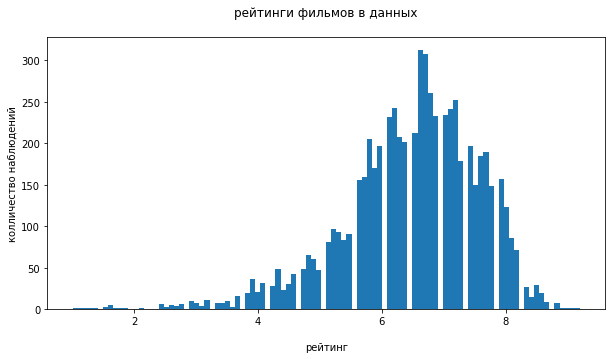

In [19]:
# вывожу гистограмму
plt.figure(figsize = (10,5))
plt.hist(data['ratings'], bins = 100, rwidth = 1);
plt.xlabel('\n' 'рейтинг')
plt.ylabel('колличество наблюдений')
plt.title('рейтинги фильмов в данных' '\n');

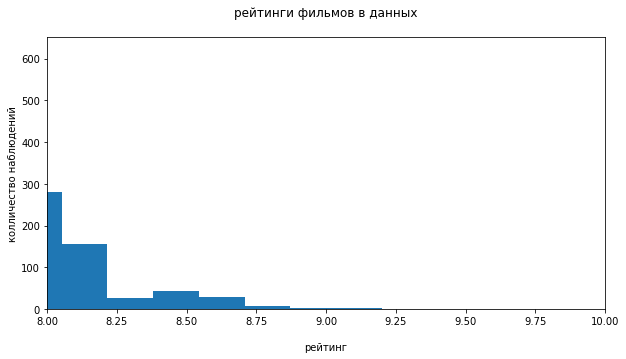

In [20]:
# вывожу гистограмму
plt.figure(figsize = (10,5))
plt.hist(data['ratings'], bins = 50, rwidth = 1);
plt.xlabel('\n' 'рейтинг')
plt.ylabel('колличество наблюдений')
plt.title('рейтинги фильмов в данных' '\n');
plt.xlim(8,10);

Посмотрим на фильмы с высоким рейтингом, они редко встречаются обычно, насколько здесь это так же. Особенно внимательно буду смотреть на фильмы после 2013 года, потому что это промежуток с данными про государственную поддержку фильмов.

In [21]:
# срез
data.loc[(data['ratings']>=8.7) & (data['show_start_date'].dt.year>=2013) & data['production_country'].str.contains('Россия')]

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
1467,Друзья друзей,111014513,2013-12-19 00:12:00,Художественный,"ООО ""ЕМ Продакшн""",Россия,А.Аксененко,"Г.Малков, В.Поляков, Г.Андреасян, С.Андреасян",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,9.2,"комедия,мелодрама",27780.0
2668,Режиссёр мозга,111013115,2015-08-12 00:12:00,Художественный,Гарифуллин Рамиль Рамзиевич,Россия,Р.Гарифуллин,Р.Гарифуллин,«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,8.7,"боевик,триллер,драма",NaN
3215,"Машкины Cтрашилки. Серия ""Фантастический расск...",114001616,2016-06-10 00:12:00,Анимационный,"ООО Студия ""АНИМАККОРД"" - ANIMACCORD LTD.",Россия - Республика Кипр,Д.Червяцов,"Д.Ловейко, О.Кузовков",«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,8.7,"фантастика,драма,комедия",NaN
6146,"Анимационный фильм ""Малышарики 3"", серия ""Нужн...",114005118,2018-08-27 00:12:00,Анимационный,"ООО ""Продюсерский центр ""Рики""",Россия,М.Мошкова,"И.Попов, Ю.Осетинская",«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,9.0,"мультфильм,детский,семейный",NaN
6149,"Анимационный фильм ""Малышарики 3"", серия ""Пода...",114005418,2018-08-27 00:12:00,Анимационный,"ООО ""Продюсерский центр ""Рики""",Россия,М.Мошкова,"И.Попов, Ю.Осетинская",«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,9.0,"мультфильм,детский,семейный",NaN


Я вывела топ рейтинга российских фильмов после 2013 года и максимальный рейтинг из всех фильмов у фильма "Друзья друзей". Легко увидеть, что это ошибка и его рейтинг на кинопоиске на самом деле 3.3. Заменю это значение.

In [22]:
# заменяю значения
data.loc[1467,'ratings'] = 3.3

<div class="alert-success" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ✔️</b>

Данные приведены к нужным типам правильно, молодец, что разобралась с аномальными значениями рейтинга.</div>

# Шаг 2.2. Изучите пропуски в датафрейме

- Объясните, почему заполнили пропуски определённым образом или почему не стали этого делать.

In [23]:
# Вывожу пропуски
pd.DataFrame(data.isna().mean()*100).rename(columns = {0:"percent"}).style.background_gradient('coolwarm')

,percent
title,0.000000
pu_number,0.000000
show_start_date,0.000000
type,0.000000
film_studio,0.241384
production_country,0.026820
director,0.120692
producer,7.617004
age_restriction,0.000000
refundable_support,95.574628


Видно, что очень много пропусков в данных про финансы фильма, причём одинаковое число - скорее всего это связано с источником данных о финансах. Есть довольно много пропусков в данных о выручке фильмов. Среднее колличество в данных о реётинге, жанре и продюсере. И очень мало в данных о студии, стране и режиссере.

In [24]:
#столбчатая диаграмма
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = 0, legend = False, fontsize = 16)
            .set_title('Проценты пропусков' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

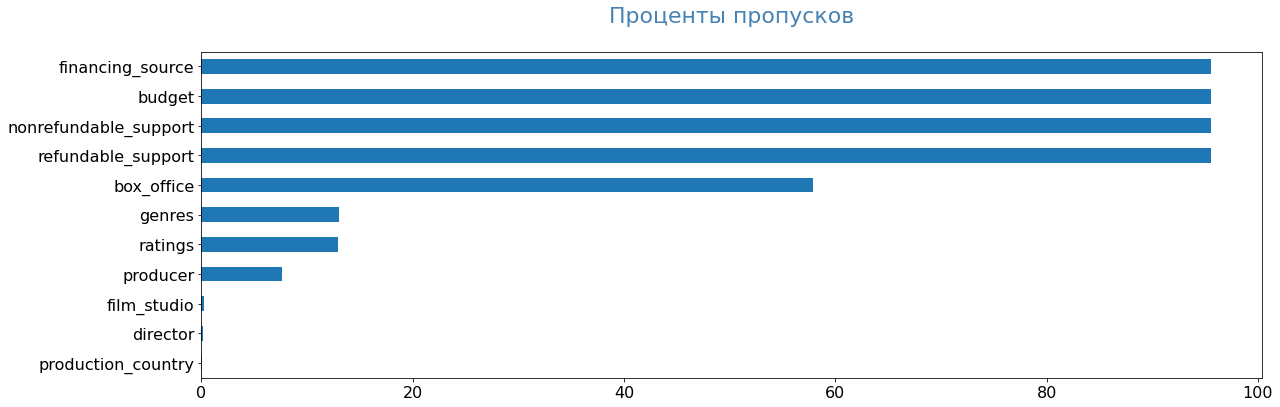

In [25]:
pass_value_barh(data)

На графике мы снова видим процент совпадений пропусков у некоторых переменных.
Для начала начнём заполнять пропуски с переменных, где их очень мало. Их насколько мало, что кажется, что можно их точечно заполнить.

In [26]:
# срез с пропусками
data.query('production_country.isna()')

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
3174,"Детский юмористический киножурнал ""Ералаш. Ну ...",111001216,2016-02-09 00:12:00,Художественный,"ООО ""Продюсерский центр ЕРАЛАШ""",NaN,"Р.Светлов, И.Магитон, А.Арутюнян, Л.Мирский, А...","ООО ""Продюсерский центр ЕРАЛАШ""",«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,7.2,"детский,комедия",194527.0
4422,Мульт личности. Выпуск 5,214000410,2010-01-25 00:12:00,Художественный,NaN,NaN,NaN,NaN,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,4.0,"мультфильм,комедия",NaN


In [27]:
# заполню пропуски
data.loc[3174,'production_country'] = 'Россия'
data.loc[4422, 'production_country'] = 'Россия'

In [28]:
# срез
data.query('director.isna()')

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
763,"Три звезды. Концерт в Waldbuhne Theater, Берли...",126003512,2012-12-04 00:12:00,Прочие,Райзинг Алтернатив,Великобритания,NaN,Вальдбюне Театр,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,NaN,NaN,44350.0
1731,Помпеи. Британский музей,126003413,2013-09-11 00:12:00,Прочие,"МортуСкрин, Британский музей",Великобритания,NaN,Британский музей,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3822,Зур концерт (Большой концерт).,217027010,2010-06-24 00:12:00,Художественный,"ООО ""Барс Рекордс""",Россия,NaN,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4033,"Ганс Сэйфуллин ""Авылым чишмэлэре. Ганс Сэйфулл...",217017310,2010-04-22 00:12:00,Художественный,"ООО ""Барс-Рекордс""",Россия,NaN,NaN,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4279,Изге Вэли (Святой Валентин),217020610,2010-05-20 00:12:00,Художественный,"ООО ""Барс Рекордс""",Россия,NaN,NaN,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4396,Bon Jovi. The Circle Tour,126001710,2010-11-11 00:12:00,Прочие,Эншутц Интертейнмент Груп,США,NaN,Эншутц Интертейнмент Груп,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,7.9,"концерт,музыка",NaN
4422,Мульт личности. Выпуск 5,214000410,2010-01-25 00:12:00,Художественный,NaN,Россия,NaN,NaN,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,4.0,"мультфильм,комедия",NaN
4904,Георг Фридрих Гендель. Мессия. Оратория. Корол...,126001111,2011-04-25 00:12:00,Прочие,Опус Арт,Великобритания,NaN,Короевский колледж Кембриджа,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4923,Питер Гэбриэл и New Blood Orchestra 3D,126002711,2011-11-11 00:12:00,Прочие,Омниверс Визион,Великобритания,NaN,Омниверс Визион,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,6.7,"концерт,музыка",NaN


Это записи концертов, у которых действительно нет режиссера. Пропусков в названиях студий тоже довольно мало. Я заменю пропуски в категориальных переменных director, film_studio, producer и genre на значение unknown.

In [29]:
# заполняю пропуски
data[['producer', 'director', 'film_studio', 'genres']] = (
    data[['producer', 'director', 'film_studio', 'genres']].fillna('unknown')
)

<div class="alert-success" style="border-radius: 10px; padding: 20px">
<b>Комментарий ревьюера V2 ✔️</b>

Отлично! 👍</div>

<div class="alert-warning" style="border-radius: 10px; padding: 20px">
<b>Комментарий ревьюера ⚠️</b>
    
Пропуски в столбцах, содержащие строковые данные, например 'director', 'producer', 'genres' можно заменить на какую-то заглушку типа "Unknown".
</div>

In [30]:
# применяем knn для подмножества данных
d = (data.query('box_office.notna()')[['ratings', 'box_office']])
imputer = KNNImputer(n_neighbors = 5, weights = 'uniform', metric = 'nan_euclidean')
imputer.fit(d)
dtrans = imputer.transform(d)

In [31]:
# запишем полученные значения в датафрейм
data.loc[data['box_office'].notna(), 'ratings']= (pd.DataFrame(dtrans, index = data.loc[data['box_office'].notna(), 'ratings']
                                                               .index ).loc[:,0])

Пропусков в данных о кинопрокате слишком много, мы не можем их ни заполнить на какие-то другие ни удалить, так как это сильно повлияет на наш анализ.
Посмотрим на пропуски в данных о бюджете и финансах фильма. Поскольку все эти пропуски абсолютно одинаковые (полностью совпадают), посмотрим только на примере одной переменной.

In [32]:
# срез данных с известным бюджетом
data.query('budget.notna()').groupby('production_country')['type'].count()

production_country
Россия                                        314
Россия - Грузия                                 1
Россия, Армения                                 1
Россия, Бельгия, Финляндия                      1
Россия, Германия                                2
Россия, Германия, Великобритания                1
Россия, Германия, Казахстан, Польша, Китай      1
Россия, Италия                                  2
Россия, Латвия, Чешская Республика              1
Россия, Сербия                                  1
Россия, Украина, Польша                         1
Россия, Франция, Латвия                         1
Россия-Китай                                    1
Россия-Словакия-Чехия                           1
Россия-Украина                                  1
Name: type, dtype: int64

Мы знаем данные о бюджете и финансировании только тех фильмов, в которых принимала участие Россия (потому что такой источник этих данных).

In [33]:
# срез
data.loc[data['production_country'].str.contains('Россия') & data['budget'].isna()]['type'].count()


1637

При этом есть 1637 наблюдений с фильмами с участием России, где тем не менее данные о бюджете отсутствуют. 

Посмотрю на статистики финансовой поддержки

In [34]:
# вывожу статистику
data['refundable_support'].describe().apply('{:,.0f}'.format)

count            330
mean      11,936,364
std       24,974,945
min                0
25%                0
50%                0
75%       15,000,000
max      180,000,000
Name: refundable_support, dtype: object

In [35]:
# вывожу статистику
data['nonrefundable_support'].describe().apply('{:,.0f}'.format)

count            330
mean      49,233,298
std       60,073,640
min                0
25%       25,000,000
50%       30,000,000
75%       41,125,000
max      400,000,000
Name: nonrefundable_support, dtype: object

In [36]:
# смотрим значения
data['financing_source'].unique()

array([nan, 'Министерство культуры', 'Фонд кино',
       'Министерство культуры, Фонд кино'], dtype=object)

Посмотрим, возможно, что фильмы с участием РФ, у которых есть и нет данных о финансовой поддержке разничаются по годам. Такое можно было бы предположить, если бы данные о финансировании были бы только, начиная с какого-то года.

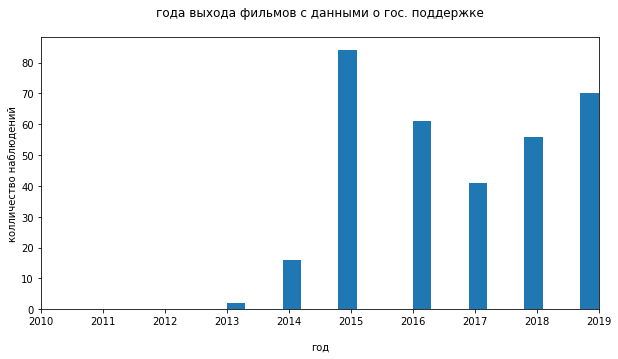

In [37]:
# вывожу гистограмму
plt.figure(figsize = (10,5))
plt.hist(data.query('budget.notna()')['show_start_date'].dt.year, bins = 20, rwidth = 1);
plt.xlabel('\n' 'год')
plt.ylabel('колличество наблюдений')
plt.xlim(2010, 2019)
plt.title('года выхода фильмов с данными о гос. поддержке' '\n');


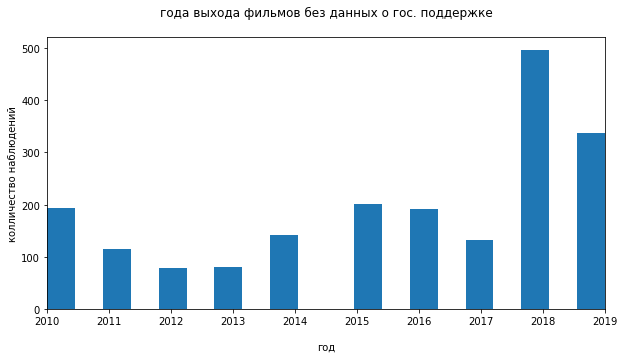

In [38]:
# вывожу гистограмму
plt.figure(figsize = (10,5))
plt.hist(data.loc[data['production_country'].str.contains('Россия'), 'show_start_date'].dt.year, bins = 20, rwidth = 1);
plt.xlabel('\n' 'год')
plt.ylabel('колличество наблюдений')
plt.xlim(2010, 2019)
plt.title('года выхода фильмов без данных о гос. поддержке' '\n');


Мы видим, что фильмы с данными о гос. поддержке выходили после 2013 года. Можно сделать вывод, что фильмы с участием РФ, выходившие после 2013 года и с пропусками в этих значениях не имеют гос. финансирования. Я заменю пропуски в refundable_support и nonrefundable_support в таких наблюдениях на 0.

<div class="alert-success" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ✔️</b>

Это логичная замена. Молодец, что так подробно рассмотрела пропуски в этих столбцах.</div>

In [39]:
# заполняю пропуски
(
    data
    .loc[(data['production_country'].str.contains('Россия')) 
         & (data['show_start_date'].dt.year>=2013) & (data['refundable_support'].isna()),'refundable_support']) = 0

(
    data
    .loc[(data['production_country'].str.contains('Россия')) 
         & (data['show_start_date'].dt.year>=2013) & (data['nonrefundable_support'].isna()),'nonrefundable_support']) = 0


# Шаг 2.3. Изучите дубликаты в датафрейме
- Проверьте, есть ли в данных дубликаты. Опишите причины, которые могли повлиять на появление дублей.

Для начала посмотрим, есть ли явные дубликаты.

In [40]:
# процент дубликатов
data.duplicated().mean()

0.0

Явных дубликатов в данных нет.

In [41]:
# дубликаты по подмножеству
display(data.duplicated(subset = ['title']).mean())
data.duplicated(subset = ['title', 'pu_number']).mean()

0.09574896070805954

0.0

Оказывается есть дубликаты по названию, но при этом у этих фильмов разные прокатные удостоверения. Посмотрим, что это за фильмы, выберем несколько наугад.

In [42]:
# выводим дубликаты
display(data.loc[data['title'] == data.loc[data.duplicated(subset = ['title']),'title'].values[5]])
data.loc[data['title'] == data.loc[data.duplicated(subset = ['title']),'title'].values[4]]

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
121,Гарри Поттер и кубок огня /По роману Дж.К.Ролинг/,221004816,2016-02-09 00:12:00,Художественный,"Уорнер Бразерс, Хэйдэй Филмз",США - Великобритания,Майк Ньюэлл,Дэйвид Хейман,«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.9,"фэнтези,приключения,семейный",NaN
122,Гарри Поттер и кубок огня /По роману Дж.К.Ролинг/,121026216,2016-09-23 00:12:00,Художественный,"Уорнер Бразерс, Хэйдэй Филмз",США - Великобритания,Майк Ньюэлл,Дэйвид Хейман,«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.9,"фэнтези,приключения,семейный",843310.0
4407,Гарри Поттер и кубок огня /По роману Дж.К.Ролинг/,221134410,2010-11-29 00:12:00,Художественный,"Уорнер Бразерс, Хэйдэй Филмз",США - Великобритания,Майк Ньюэлл,Дэйвид Хейман,«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.9,"фэнтези,приключения,семейный",NaN


,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
112,Гарри Поттер и узник Азкабана /По роману Дж.К....,221005016,2016-02-09 00:12:00,Художественный,"Хэйдей Филмз, 1492 Пикчерз, Уорнер Бразерс",США,Альфонсо Куарон,Майкл Барната,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,8.2,"фэнтези,приключения,семейный",NaN
113,Гарри Поттер и узник Азкабана /По роману Дж.К....,121026116,2016-09-23 00:12:00,Художественный,"Хэйдей Филмз, 1492 Пикчерз, Уорнер Бразерс",США,Альфонсо Куарон,Майкл Барната,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,8.2,"фэнтези,приключения,семейный",1125302.0
4173,Гарри Поттер и узник Азкабана /По роману Дж.К....,221135310,2010-11-30 00:12:00,Художественный,"Хэйдей Филмз, 1492 Пикчерз, Уорнер Бразерс",США,Альфонсо Куарон,Майкл Барната,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,8.2,"фэнтези,приключения,семейный",NaN


Действительно эти фильм - дубликаты, хоть у них почему-то и разные прокатные удостоверения. Зато видно, что у них одинаковый рейтинг, можно на всякий случай проверить, по подмножестве - название+рейтинг.

In [43]:
# дубликаты по подмножеству
data.duplicated(subset = ['title', 'ratings']).mean()

0.09534665415046266

Есть действительно небольшая разница. Посмотрим на фильмы, у которых дублируются названия, но разный рейтинг. 

In [44]:
# вывожу срез
for i in range(len(data.loc[data.duplicated(subset = ['title']) & ~data.duplicated(subset = ['title', 'ratings']),'title'])):
    (
        display(data
        .loc[data['title'] == data
             .loc[data.duplicated(subset = ['title']) & ~data.duplicated(subset = ['title', 'ratings']),'title'].values[i]])
    )
        

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
3772,"Легион_.(Фильм содержит сцены ужасов, насилия ...",121000310,2010-01-25 00:12:00,Художественный,Болд Филмз,США,Скотт Стюарт,"Дэвид Ланкастер, Майкл Литвак",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.2,unknown,560.0
4027,"Легион_.(Фильм содержит сцены ужасов, насилия ...",221007410,2010-02-05 00:12:00,Художественный,Болд Филмз,США,Скотт Стюарт,"Дэвид Ланкастер, Майкл Литвак",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,NaN,unknown,NaN


,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
3597,Три сестры,111004417,2017-06-09 00:12:00,Художественный,"ООО ""РТВ"", АО ""ТПО ""Киностудия им. М.Горького""...",Россия,Ю.Грымов,"Ю.Грымов, С.Зернов",«16+» - для детей старше 16 лет,0.0,25000000.0,37878787.0,Министерство культуры,5.56,unknown,1067649.0
6700,Три сестры,114001219,2019-03-15 00:12:00,Анимационный,"ФГУП ""ТПО ""Киностудия ""Союзмультфильм""",Россия,С.Андрианова,Б.Машковцев,«12+» - для детей старше 12 лет,0.0,0.0,NaN,NaN,NaN,unknown,NaN


,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
6242,Руби и повелитель воды,124003718,2018-09-27 00:12:00,Анимационный,Итс Картун Анимейшн Студио,КНР,Дин Ши,Ван Юньфэй,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.72,unknown,4326532.95
7236,Руби и повелитель воды,124007619,2019-09-30 00:12:00,Анимационный,Итс Картун Анимейшн Студио,КНР,Дин Ши,Ван Юньфэй,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,NaN,unknown,NaN


Интересно, что два из трёх таких случаев действительно являлись дубликами просто с пропусков в рейтинга, а вот третий случай - это действительно два разных фильма. Я удалю дубликаты по подмножеству название + рейтинг и руками удалю два остальных фильма.

<div class="alert-success" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера V2 ✔️</b>
    
📌 Вывести все дубликаты по столбцу можно так:
    
```python
df[df.duplicated(subset = ['puNumber'], keep = False)]
```
</div>

In [45]:
# удаляю
data = data.drop_duplicates(subset = ['title', 'ratings']).reset_index(drop = True)
data = data.drop([3772, 6242]).reset_index(drop = True)

<div class="alert-warning" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ⚠️</b>
    
Я бы предложил предложил проверить дубликаты по паре "название" - "номер прокатного удостоверения".
    
Также, перед удалением, стоит вывести на экран примеры дубликатов по названию фильма.
</div>

In [46]:
# уникальные значения
data['type'].unique()

array(['Художественный', 'Анимационный', 'Прочие', 'Документальный',
       'Научно-популярный', ' Художественный', ' Анимационный',
       'Музыкально-развлекательный'], dtype=object)

Есть проблема в пробеле в начале жанра "Художественный", таким типом проблем займёмся на следующем шаге.

In [47]:
# уникальные значения
data['film_studio'].unique()

array(['Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикчерз, Тиг Продакшнз',
       'Киностудия "Мосфильм"',
       'Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Платт Продакшнз, Рилейтивити Медиа, Спайгласс Интертейнмент, Стилкин Филмз, Топ Кау Продакшнз',
       ...,
       'Дэниел Гродник Продакшнз, Вандерфилм Медиа Корпорэйшн, Импринт Интертейнмент, Вор Хорс Интертейнмент, Пимиента ',
       'Никелодеон Анимейшн Студиос, Спин Мастер',
       'Анимаккорд Лтд., ООО Студия "АНИМАККОРД"'], dtype=object)

In [48]:
# подсчёт значений
len(data['film_studio'].unique())

5424

Есть 5424 разных названий студий. На первый взгляд сложно увидеть, есть ли тут дубликаты, но из названий можно понять, что проблемы могут возникнуть либо с названиями, дублирующими строчный и заглавный текст, либо с транслитерацией английских названий.

In [49]:
# унификация шрифта
data['film_studio'] = data['film_studio'].str.lower()

In [50]:
# считаем значения
len(data['film_studio'].unique())

5387

Получилось избавиться от 37 дубликатов.

# Шаг 2.4. Изучите категориальные значения

- Посмотрите, какая общая проблема встречается почти во всех категориальных столбцах;
- Исправьте проблемные значения в поле `type`.

<div id="accordion">
    <div class="card">
        <div class="card-header" id="headingThree">
            <button class="btn btn-link collapsed" data-toggle="collapse" data-target="#collapseHint_1" aria-expanded="false" aria-controls="collapseHint_1">Подсказка</button>
        </div>
        <div id="collapseHint_1" class="collapse" aria-labelledby="headingThree" data-parent="#accordion">
            <div class="card-body">
В поле <code>type</code> есть несколько значений, у которых появился пробел в начале строки. Самый простой способ их «починить» -- использовать метод <a href="https://pandas.pydata.org/docs/reference/api/pandas.Series.str.strip.html#pandas.Series.str.strip">.str.strip</a>. Этот метод удаляет все пробелы, которые встречаются в начале и в конце строки. Применяют его таким образом:<br>
<code>df['type'].str.strip()</code>
            </div>
        </div>
    </div>
</div>

Посмотрим еще раз на типы переменных.

In [51]:
# вывожу типы
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6744 entries, 0 to 6743
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  6744 non-null   object        
 1   pu_number              6744 non-null   object        
 2   show_start_date        6744 non-null   datetime64[ns]
 3   type                   6744 non-null   object        
 4   film_studio            6744 non-null   object        
 5   production_country     6744 non-null   object        
 6   director               6744 non-null   object        
 7   producer               6744 non-null   object        
 8   age_restriction        6744 non-null   object        
 9   refundable_support     1551 non-null   float64       
 10  nonrefundable_support  1551 non-null   float64       
 11  budget                 327 non-null    float64       
 12  financing_source       327 non-null    object        
 13  rat

С точки зрения типов данных, сейчас всё нормально. Единственный спорный пункт - это то, что pu_number включает идентификационный номер, а является сейчас переменной типа object. Но на самом деле, это не является проблемой, потому что мы не будем делать числовые операции с номером, а наличие пропуска усложняет перевод в тип int, поэтому я оставлю его object.

Теперь посмотрим на значения категориальных переменных. Я уже видела, что в переменной type повторялось одно и то же значение "Художественный" с разницей только в пробеле. Я также видела уже значения в film_studio, которых очень много. Посмотрим на остальные переменные.

<div class="alert-success" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ✔️</b>

Да, основной проблемой в категориальных столбцах можно назвать несколько значений в одном поле, что как раз и затрудняет категоризацию.
</div>

In [52]:
# вывожу значения
display(data['type'].unique())
display(data['production_country'].unique())
display(data['director'].unique())
display(data['producer'].unique())
display(data['age_restriction'].unique())
display(data['financing_source'].unique())
data['genres'].unique()

array(['Художественный', 'Анимационный', 'Прочие', 'Документальный',
       'Научно-популярный', ' Художественный', ' Анимационный',
       'Музыкально-развлекательный'], dtype=object)

array(['США', 'СССР', 'Франция', 'СССР, Венгрия',
       'Германия-Великобритания', 'Великобритания - Италия',
       'Чехословакия', 'США - Франция - Турция', 'Новая Зеландия',
       'Канада - Франция - Испания', 'США-Германия',
       'США - Великобритания', 'Великобритания', 'США - Германия',
       'Франция - Мексика - США', 'Россия, Казахстан, США',
       'СССР, Швеция', 'СССР, Франция, Англия, Куба, ГДР', 'Германия',
       'Великобритания-США-Германия-КНР',
       'СССР, ЧССР, Западный Берлин, ПНР', 'СССР, Италия', 'Гонконг, КНР',
       'США - Франция', 'США - Япония - Франция - Великобритания',
       'Гонконг - Сингапур - Таиланд - Великобритания', 'США-Канада',
       'Франция - Италия - Великобритания - США', 'Франция - США',
       'Ирландия-Великобритания-Германия', 'Чехия', 'США-Австралия',
       'СССР, Финляндия', 'США-Франция-Великобритания-Австрия',
       'США - Бельгия', 'США - Ирландия - Великобритания',
       'Великобритания - США',
       'Люксембург - Нидерл

array(['Кевин Костнер', 'Е.Матвеев', 'Тимур Бекмамбетов', ...,
       'Ник Пауэлл', 'А.Беляев', 'И.Трусов'], dtype=object)

array(['Дэвид Валдес, Кевин Костнер, Джейк Эбертс', 'unknown',
       'Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит', ...,
       'Поппи Бегум, Ник Пойнц',
       'Джефф Боулер, Дэниэл Гродник, Луильо Руис, Брэт Саксон, Кирк Шоу',
       'Дженнифер Додж'], dtype=object)

array(['«18+» - запрещено для детей', '«6+» - для детей старше 6 лет',
       '«12+» - для детей старше 12 лет',
       '«16+» - для детей старше 16 лет',
       '«0+» - для любой зрительской аудитории'], dtype=object)

array([nan, 'Министерство культуры', 'Фонд кино',
       'Министерство культуры, Фонд кино'], dtype=object)

array(['боевик,драма,мелодрама', 'драма,военный',
       'фантастика,боевик,триллер', 'драма', 'мелодрама,комедия',
       'мюзикл,мелодрама,комедия', 'комедия,криминал',
       'боевик,триллер,детектив', 'боевик,драма,приключения',
       'драма,спорт', 'триллер,драма,мелодрама', 'комедия,мелодрама',
       'драма,мелодрама,комедия', 'драма,мелодрама', 'драма,история',
       'драма,мелодрама,семейный', 'комедия,мелодрама,криминал',
       'комедия', 'боевик,драма,криминал', 'драма,комедия',
       'ужасы,фантастика,комедия', 'мультфильм,короткометражка,мелодрама',
       'драма,криминал', 'мультфильм,фантастика,фэнтези',
       'триллер,драма,криминал', 'драма,мелодрама,биография',
       'драма,комедия,военный', 'фантастика,драма,детектив',
       'мюзикл,семейный', 'unknown', 'военный,приключения,драма',
       'документальный,драма', 'драма,биография,история',
       'боевик,триллер,драма', 'фэнтези,боевик',
       'боевик,комедия,криминал', 'мюзикл,комедия,детский',
       'комед

В остальных категориальных переменных нет такой проблемы с пробелами. Удалим пробелы в начале и в конце строки у type.ё

In [53]:
# удаляем пробелы
data['type'] = data['type'].str.strip()

In [54]:
# проверяем данные
data['type'].unique()

array(['Художественный', 'Анимационный', 'Прочие', 'Документальный',
       'Научно-популярный', 'Музыкально-развлекательный'], dtype=object)

<div class="alert-success" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ✔️</b>

Столбец `type` обработан верно. 👌</div>

Получилось избавиться от дублирования типа. Посмотрим, не появились ли в данных новые дубликаты из-за замены.

In [55]:
# проверяю дубликаты
data.duplicated().mean()

0.0

Всё нормально, новых дубликатов не возникло.

# Шаг 2.5. Проверьте количественные значения

- Проверьте, обнаружились ли в таких столбцах подозрительные данные. Как с такими данными лучше поступить?

<div id="accordion">
    <div class="card">
        <div class="card-header" id="headingThree">
            <button class="btn btn-link collapsed" data-toggle="collapse" data-target="#collapseHint_budget" aria-expanded="false" aria-controls="collapseHint_budget">Подсказка</button>
        </div>
        <div id="collapseHint_budget" class="collapse" aria-labelledby="headingThree" data-parent="#accordion">
            <div class="card-body">
Обратите внимание на описание столбца <code>budget</code>. Как этот столбец соотносится с двумя другими: <code>refundable_support</code> и <code>nonrefundable_support</code>?
            </div>
        </div>
    </div>
</div>

Посмотрим на количественные переменные. С рейтингом я уже поработала в предыдущей секции, чтобы поменять формат данных. Теперь посмотрим на refundable_support, nonrefundable_support, budget и box_office. 

Бюджет фильма не должен быть меньше, чем сумма финансовой поддержки, проверим это

In [56]:
# срез
print(data.loc[data['budget']<data['refundable_support']+data['nonrefundable_support']]['type'].count())
data.loc[data['budget']<data['refundable_support']+data['nonrefundable_support']]['budget'].mean()

17


0.0

Оказывается, есть 17 фильмов, для которых это неравенство неверно, причём у этих фильмов нулевой бюджет. Лучше заменить их значения для бюджета на сумму государственных денег.

In [57]:
# заменяю значения
data.loc[data['budget']<data['refundable_support']+data['nonrefundable_support'], 'budget'] = (
    data.loc[data['budget']<data['refundable_support']+data['nonrefundable_support'], 'refundable_support']+
    data.loc[data['budget']<data['refundable_support']+data['nonrefundable_support'], 'nonrefundable_support']
)

Посмотрим, остались ли фильмы с нулевым бюджетом.

In [58]:
# срез
data.loc[data['budget']==0]

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office


<div class="alert-success" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ✔️</b>

Хорошая проверка и такая замена возможна. 👌</div>

Таких фильмов нет и это хорошо! Теперь посмотрим на распределение box_office. Для наглядности построю распределение сборов на логарифмической шкале.

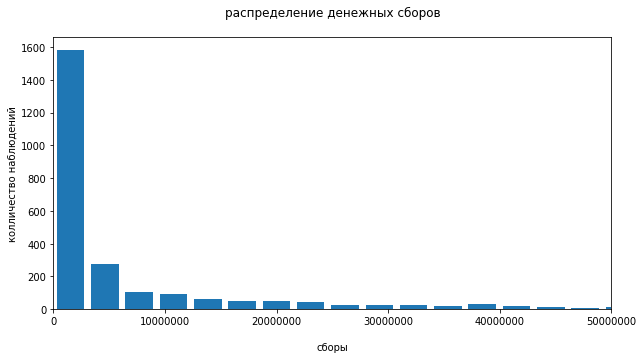

In [59]:
# гистограмма
plt.figure(figsize = (10,5))
plt.hist(data['box_office'], bins = 1000, rwidth = 0.8);
plt.xlabel('\n' 'сборы')
plt.ylabel('колличество наблюдений')
plt.ticklabel_format(useOffset=False, style='plain')
plt.xlim(0, 50000000)
plt.title('распределение денежных сборов' '\n');

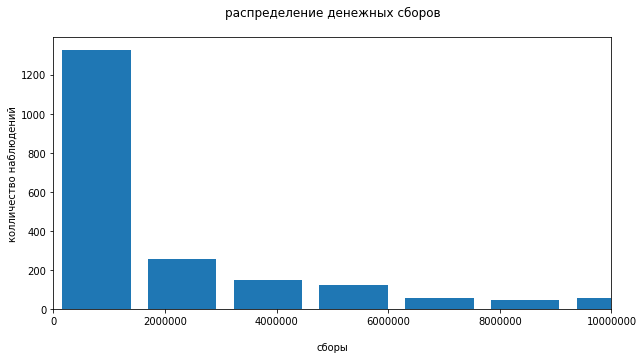

In [60]:
# гистограмма
plt.figure(figsize = (10,5))
plt.hist(data['box_office'], bins = 2000, rwidth = 0.8);
plt.xlabel('\n' 'сборы')
plt.ylabel('колличество наблюдений')
plt.ticklabel_format(useOffset=False, style='plain')
plt.xlim(0, 10000000)
plt.title('распределение денежных сборов' '\n');

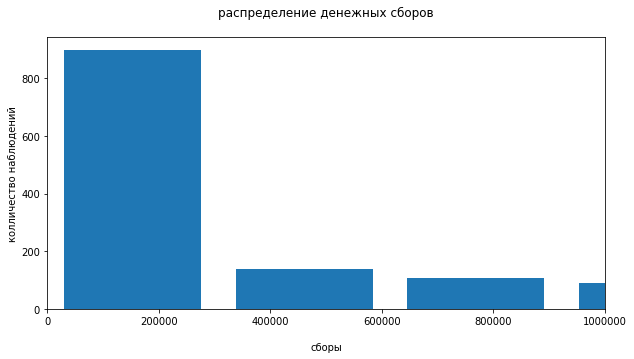

In [61]:
# гистограмма
plt.figure(figsize = (10,5))
plt.hist(data['box_office'], bins = 10000, rwidth = 0.8);
plt.xlabel('\n' 'сборы')
plt.ylabel('колличество наблюдений')
plt.ticklabel_format(useOffset=False, style='plain')
plt.xlim(0, 1000000)
plt.title('распределение денежных сборов' '\n');

Посмотрю на статистику переменной box_office

In [62]:
# статистика
data['box_office'].describe().apply('{:,.0f}'.format)

count            3,001
mean        75,855,307
std        238,131,639
min                  0
25%            118,650
50%          2,453,299
75%         23,969,331
max      3,073,568,691
Name: box_office, dtype: object

Оказывается, что есть фильмы с нулевыми сборами, посмотрю на них поподробнее.

In [63]:
data.loc[data['box_office']==0]['type'].count()

23

У 23 фильмов нулевые сборы, это кажется ошибкой наблюдений, удалю такие наблюдения.

In [64]:
# удаляю наблюдения
data = data.query('box_office>0 or box_office.isna()')

<div class="alert-success" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ✔️</b>

Здорово, что подробно рассмотрела и обработала столбец с бюджетом фильмов. 

</div>

# Шаг 2.6. Добавьте новые столбцы





- Создайте столбец с информацией о годе проката. Выделите год из даты премьеры фильма.

In [65]:
# добавляю год
data['year'] = data['show_start_date'].dt.year

- Создайте два столбца: с именем и фамилией главного режиссёра и основным жанром фильма. В столбцы войдут первые значения из списка режиссёров и жанров соответственно.

<div id="accordion">
    <div class="card">
        <div class="card-header" id="headingThree">
            <button class="btn btn-link collapsed" data-toggle="collapse" data-target="#collapseHint_2" aria-expanded="false" aria-controls="collapseHint_2">Подсказка</button>
        </div>
        <div id="collapseHint_2" class="collapse" aria-labelledby="headingThree" data-parent="#accordion">
            <div class="card-body">
Чтобы создать такие столбцы, лучше всего использовать собственную функцию. Эту функцию можно применить к двум столбцам сразу. 
            </div>
        </div>
    </div>
</div>

In [66]:
# создаю новые переменные
data['main_director'] = data['director'].str.split(',', n = 1, expand = True)[0]
data['main_genres'] = data['genres'].str.split(',', n = 1, expand = True)[0]

<div class="alert-success" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ✔️</b>

Здесь не обязательно использовать функцию, можно воспользоваться преимуществом Pandas и работать со всем столбцом:

```python
df['new_genre'] = df['genres'].str.split(',', n = 1, expand = True)[0]
```
</div>

- Посчитайте, какую долю от общего бюджета фильма составляет государственная поддержка.

У нас нет наблюдения с нулевым буджетом, поэтому можно смело на него делить, аномалий не возникнет.

In [67]:
# создаю переменную
data['fraction'] = (data['refundable_support']+data['nonrefundable_support'])/data['budget']

In [68]:
# выводим статистику для fraction
data['fraction'].describe().apply('{:,.1f}'.format)

count    327.0
mean       0.5
std        0.2
min        0.0
25%        0.4
50%        0.6
75%        0.7
max        1.0
Name: fraction, dtype: object

Доля выглядит адекватно.

<div class="alert-success" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ✔️</b>

Дополнительные данные рассчитаны и добавлены правильно.

</div>

<div class="alert-warning" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ⚠️</b>

Шаг предобработки данных стоит закончить кратким выводом о проделанной работе. </div>

На данном шаге я занималась предобработкой данных: для некоторых переменных поменяла их типа и обработала аномалии в данных. 
По возможности заполнила пропуски: где-то заполнила известными значениями, где-то вместо пропусков вставила значение unknown, пропуск в райтинге заполнила используя метод knn, а дл российских фильмов после 2013 года заполнила пропуски в финансовой поддержке нулями.
Я нашла около 9% дубликатов и хотя у этих фильмов были разные прокатные удостоверения, тем не менее они действительно являлись дубликатами и я их удалила. 

<div class="alert-success" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера V2 ✔️</b>

Супер! Плюс, рассчитаны и добавлены дополнительные данные...
</div>

# Шаг 3. Проведите исследовательский анализ данных


- Посмотрите, сколько фильмов выходило в прокат каждый год. Обратите внимание, что данные о прокате в кинотеатрах известны не для всех фильмов. Посчитайте, какую долю составляют фильмы с указанной информацией о прокате в кинотеатрах.

In [69]:
# группирую по годам
data.groupby('year')['type'].count()

year
2010    757
2011    476
2012    510
2013    584
2014    723
2015    651
2016    765
2017    496
2018    872
2019    887
Name: type, dtype: int64

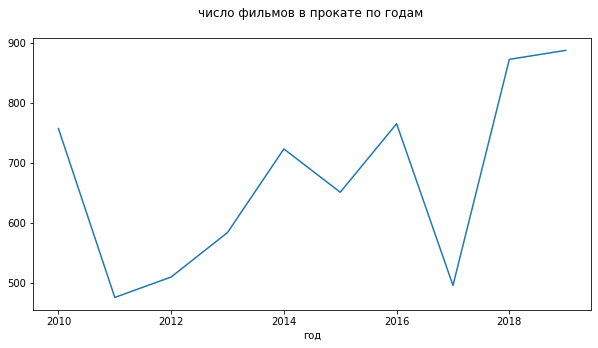

In [70]:
# график
data.groupby('year')['type'].count().plot(figsize = (10,5), xlabel = 'год', title = 'число фильмов в прокате по годам \n');

In [71]:
# доля фильмов с информацией о сборах
(data.groupby('year')['box_office'].count()/data.groupby('year')['type'].count()).apply('{:,.2f}'.format)

year
2010    0.11
2011    0.21
2012    0.22
2013    0.29
2014    0.35
2015    0.65
2016    0.65
2017    0.72
2018    0.54
2019    0.58
dtype: object

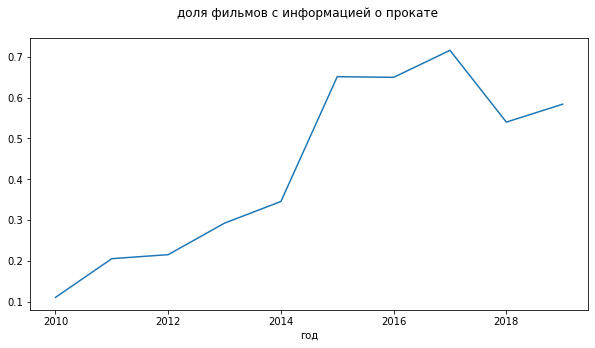

In [72]:
# график 
(data.groupby('year')['box_office']
 .count()/data.groupby('year')['type'].
 count()).plot(figsize = (10,5), xlabel = 'год', title = 'доля фильмов с информацией о прокате \n');

Из первого графика видно, что динамика выхода в прокат у фильмов была очень нелинейной: в 2011 и 2017 годах были провалы. Теперь посмотрим на сумму сборов.

Составим теперь общую информацию о фильмах по годам.

In [73]:
# сводная таблица
pivot_data = pd.pivot_table(data, values = ['type','box_office'], index = 'year', aggfunc = ['count'])
pivot_data.columns = pivot_data.columns.droplevel()
pivot_data = pivot_data.rename(columns = {'type':'production'})
pivot_data['percent'] = (pivot_data['box_office']/pivot_data['production']).apply('{:.0%}'.format)
pivot_data

,box_office,production,percent
year,,,
2010,84,757,11%
2011,98,476,21%
2012,110,510,22%
2013,171,584,29%
2014,250,723,35%
2015,424,651,65%
2016,497,765,65%
2017,355,496,72%
2018,471,872,54%


<div class="alert-success" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера V2 ✔️</b>

Отлично! Теперь все нужные данные собраны в таблицу. 👌</div>

<div class="alert-warning" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ⚠️</b>
    
Давай соберем все рассчитаные данные в одну сводную таблицу со столбцами:

- год выпуска
- всего выпущено фильмов
- количество фильмов с информацией о сборах
- доля

</div>

- Изучите, как менялась динамика проката по годам. В каком году сумма сборов была минимальной? А максимальной?

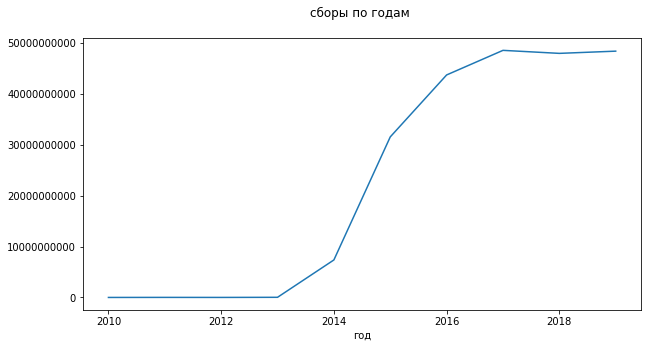

In [74]:
# график
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
ax.plot(data.groupby('year')['box_office'].sum())
ax.ticklabel_format(useOffset=False, style='plain')
plt.xlabel('год')
plt.title('сборы по годам \n')
plt.show()

На графике видно, что в 2010 - 2013 года практически одинаково минимальны, в то время как 2017 - 2019 года максимальны по сборам. Посмотрим на точные цифры.

In [75]:
# сумма по годам
pd.DataFrame(data.groupby('year')['box_office'].sum().sort_values()).style.background_gradient('coolwarm').format('{:,.0f}')

,box_office
year,
2010,"2,374,340"
2012,"6,463,371"
2011,"13,944,390"
2013,"29,768,531"
2014,"7,372,594,277"
2015,"31,553,351,322"
2016,"43,728,069,504"
2018,"47,969,406,315"
2019,"48,404,289,345"


Лидером по прокату оказался 2017 год, а самым минимальным - 2010.

<div class="alert-success" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ✔️</b>

Суммарные сборы проанализированы правильно. Молодец, расчеты представлены отлично и в таблице и на графике. 👍</div>

- С помощью сводной таблицы посчитайте среднюю и медианную сумму сборов для каждого года.

In [76]:
# строим сводную таблицу
pd.pivot_table(data, values = 'box_office', index = 'year', aggfunc = ['mean', 'median']).style.format('{:,.0f}')

,mean,median
,box_office,box_office
year,,
2010,"28,266","2,085"
2011,"142,290","3,042"
2012,"58,758","7,170"
2013,"174,085","3,880"
2014,"29,490,377","28,420"
2015,"74,418,281","4,435,043"
2016,"87,984,043","3,712,390"
2017,"136,793,004","10,387,327"


Из сводной таблицы видно, как сильно отличаются средние и медианные сборы для каждого года. Это значит, что распределение сборов для каждого года очень сильно скошенное. В таком случае медиана будет более правильным показателем для использования.

<div class="alert-success" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ✔️</b>

Средние и медианные сборы по годам посчитаны верно.

Действительно, такой разброс между медианой и средним может говорить о большом количестве фильмов-середнячков и нескольких удачных проектах.</div>

- Определите, влияет ли возрастное ограничение аудитории («6+», «12+», «16+», «18+» и т. д.) на сборы фильма в прокате в период с 2015 по 2019 год? Фильмы с каким возрастным ограничением собрали больше всего денег в прокате? Меняется ли картина в зависимости от года? Если да, предположите, с чем это может быть связано.

Для начала сгруппируем данные по ограничениям и посмотрим на медианные сборы. 

In [77]:
# группировка
(
    data
    .query('year>=2015')
    .groupby('age_restriction')['box_office']
    .sum().to_frame().sort_values(by = 'box_office', ascending = False).style.format('{:,.0f}')
)

,box_office
age_restriction,
«16+» - для детей старше 16 лет,"68,939,997,509"
«12+» - для детей старше 12 лет,"58,930,792,691"
«6+» - для детей старше 6 лет,"54,963,417,904"
«18+» - запрещено для детей,"36,679,079,372"
«0+» - для любой зрительской аудитории,"703,345,315"


Видим, что наибольшие общие сборы у фильмов с ограничением 16+, в то время как у фильмов 0+ наименьшие сборы. 

<div class="alert-success" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера V2 ✔️</b>

Да, все верно.</div>

In [78]:
# сводная таблица
restriction_pivot = (
    pd
    .pivot_table(data.query('year>=2015'), values = 'box_office', index = 'age_restriction', columns = 'year', aggfunc = 'sum')
)
restriction_pivot.style.background_gradient('coolwarm').format('{:,.0f}')

year,2015,2016,2017,2018,2019
age_restriction,,,,,
«0+» - для любой зрительской аудитории,"273,367,768","150,183,549","229,598,930","32,449,002","17,746,067"
«12+» - для детей старше 12 лет,"11,957,220,583","12,178,337,053","7,851,389,701","14,267,291,661","12,676,553,694"
«16+» - для детей старше 16 лет,"8,273,451,819","14,359,266,775","18,742,889,949","14,820,922,308","12,743,466,658"
«18+» - запрещено для детей,"3,182,668,084","4,987,137,720","9,651,495,581","8,743,768,721","10,114,009,267"
«6+» - для детей старше 6 лет,"7,866,643,068","12,053,144,408","12,086,142,146","10,104,974,623","12,852,513,659"


<div class="alert-success" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера V2 ✔️</b>

Можно в сводную таблицу сразу добавить итоги: 👇</div>

In [106]:
# Код ревьюера
pd.set_option('display.float_format', '{:,.2f}'.format)

data.query('year>=2015').pivot_table(
    values = 'box_office', 
    index = 'age_restriction', 
    columns = 'year', aggfunc = 'sum',
    margins = True)

year,2015,2016,2017,2018,2019,All
age_restriction,,,,,,
«0+» - для любой зрительской аудитории,"273,367,767.78","150,183,548.67","229,598,930.00","32,449,002.11","17,746,066.82","703,345,315.38"
«12+» - для детей старше 12 лет,"11,957,220,583.41","12,178,337,053.01","7,851,389,700.67","14,267,291,660.69","12,676,553,693.67","58,930,792,691.45"
«16+» - для детей старше 16 лет,"8,273,451,818.89","14,359,266,774.80","18,742,889,949.06","14,820,922,307.93","12,743,466,658.15","68,939,997,508.83"
«18+» - запрещено для детей,"3,182,668,083.98","4,987,137,719.62","9,651,495,581.02","8,743,768,720.63","10,114,009,267.16","36,679,079,372.41"
«6+» - для детей старше 6 лет,"7,866,643,067.61","12,053,144,408.24","12,086,142,145.76","10,104,974,623.41","12,852,513,658.86","54,963,417,903.88"
All,"31,553,351,321.67","43,728,069,504.34","48,561,516,306.51","47,969,406,314.77","48,404,289,344.66","220,216,632,791.95"


Из таблицы видно, что в каждый год минимальные сборы были у фильмов 0+, а максимальные сборы были почти всегда у фильмов 16+ кроме 2015 года, когда лидером были фильмы 12+.

Это может быть связано с тем, что фильмов 0+ просто мало, а других фильмов больше. Посчитаем колличество фильмов каждой категории, выходивших в прокат каждый год.

In [79]:
# сводная таблица
(
    pd
    .pivot_table(data.query('year>=2015'), values = 'type', index = 'age_restriction', columns = 'year', aggfunc = 'count')
    .style.background_gradient('coolwarm').format('{:,.0f}')
)

year,2015,2016,2017,2018,2019
age_restriction,,,,,
«0+» - для любой зрительской аудитории,46,69,44,77,72
«12+» - для детей старше 12 лет,134,130,67,234,192
«16+» - для детей старше 16 лет,233,245,150,232,254
«18+» - запрещено для детей,169,228,169,215,243
«6+» - для детей старше 6 лет,69,93,66,114,126


Действительно, фильмов 0+ просто очень мало, а фильмов 16+ много, поэтому у них и большее высокие сборы. Интересная закономерность у фильмов 6+, их выпускалось не очень много, но при этом суммарные сборы у них довольно большие, похоже, что у таких фильмов просто очень высокие сборы.

Посмотрим на динамику сборов по категориям на диаграмме.

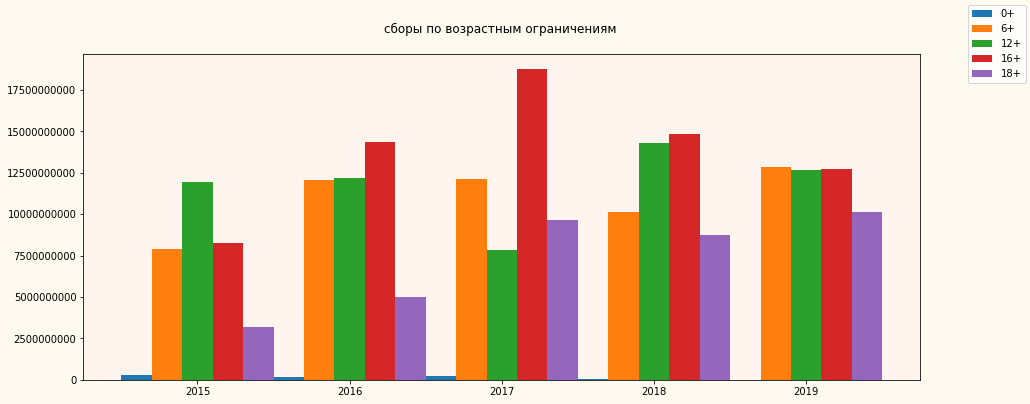

In [80]:
fig, ax = plt.subplots()
x1 = restriction_pivot.T.index - 0.4
x2 = restriction_pivot.T.index - 0.2
x3 = restriction_pivot.T.index 
x4 = restriction_pivot.T.index + 0.2
x5 = restriction_pivot.T.index + 0.4
y1 = restriction_pivot.T['«0+» - для любой зрительской аудитории']
y2 = restriction_pivot.T['«6+» - для детей старше 6 лет']
y3 = restriction_pivot.T['«12+» - для детей старше 12 лет']
y4 = restriction_pivot.T['«16+» - для детей старше 16 лет']
y5 = restriction_pivot.T['«18+» - запрещено для детей']


ax.bar(x1, y1, width = 0.2, label = '0+')
ax.bar(x2, y2, width = 0.2, label = '6+')
ax.bar(x3, y3, width = 0.2, label = '12+')
ax.bar(x4, y4, width = 0.2, label = '16+')
ax.bar(x5, y5, width = 0.2, label = '18+')
fig.legend(loc = 'upper right')
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_facecolor('seashell')
fig.set_figwidth(15)    
fig.set_figheight(6)    
fig.set_facecolor('floralwhite')
plt.title('сборы по возрастным ограничениям \n')

plt.show()

На диаграмме ещё раз видно, что в суммарных сборах фильмы 16+ стабильно занимают лидерские позиции, особенно в 2017 году заметно превыщают сборы всех остальных фильмов. Видно нагрядно насколько малы сборы 0+ по сравнению со всеми остальными фильмами. График также визуально показал, что у фильмов 18+ наблюдается положительная динамика по сборам - в 2015 они сильно отставали от остальных категорий кроме 0+, а в 2019 уже почти сто догнали. 

На данном шаге проекта я провела анализ данных о прокате и сборах фильмов. 

Динамика колличества фильмов в прокате по годам очень нелинейна, периоды роста сменяются периодами падения. При этом в данных есть данные о сборах далеко не всех фильмов, выходивших в прокат, но процент покрытия данных растёт с течением времени.

Я посмотрела на динамику общих сборов и виден экспоненциальный рост в районе 2014 года, с максимумом в 2017 году.

На последнем этапе я исследовала суммарные сборы для фильмов с различными возрастными ограничениями по годам. В каждом году у фильмов 0+ были минимальные сборы, и практически всегда у 16+ - максимальные. Во многом это объясняется колличеством фильмов в каждой категории, выходивших в прокат.

<div class="alert-danger" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ❌</b>

Ты выбрала какой-то сложный способ для сравнения сборов по возрастным категориям. 

Во-первых по заданию, нам нужно ответить на вопрос: "Фильмы с каким возрастным ограничением собрали больше всего денег в прокате?" - для этого нужно сравнить суммарные сборы по категориям.
    
Далее - проанализировать динамику суммарных сборов по годам рассматриваемого периода. Лучше всего это сделать на сгруппированных столбчатых диаграммах, где по оси X будут годы, а по Y - суммарные сборы различных возрастных категорий.
    
В конце шага с исследовательским анализом нужно написать промежуточный вывод по рассмотренным параметрам фильмов.

</div>

<div class="alert-success" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера V2 ✔️</b>

Теперь на графике можно увидеть динамику суммарных сборов по возрастным категориям.</div>

# Шаг 4. Исследуйте фильмы, которые получили государственную поддержку

На этом этапе нет конкретных инструкций и заданий — поищите интересные закономерности в данных. Посмотрите, сколько выделяют средств на поддержку кино. Проверьте, хорошо ли окупаются такие фильмы, какой у них рейтинг.

Для начала посмотрим, какой процент российских фильмов получал финансовую помощь.

In [81]:
# считаем процент
(
    data.loc[(data['refundable_support']>0) | (data['nonrefundable_support']>0)].groupby('year')['type'].count()/
    data.loc[(data['refundable_support'].notna()) & (data['nonrefundable_support'].notna())].groupby('year')['type'].count()
)


year
2013    0.025641
2014    0.115942
2015    0.422111
2016    0.321053
2017    0.310606
2018    0.115942
2019    0.205521
Name: type, dtype: float64

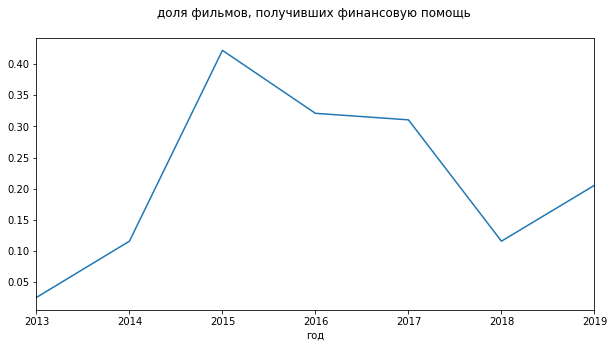

In [82]:
# график
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
ax.plot((
    data.loc[(data['refundable_support']>0) | (data['nonrefundable_support']>0)].groupby('year')['type'].count()/
    data.loc[(data['refundable_support'].notna()) & (data['nonrefundable_support'].notna())].groupby('year')['type'].count()
))
plt.xlim(2013, 2019)
plt.xlabel('год')
plt.title('доля фильмов, получивших финансовую помощь \n')
plt.show()

Процент фильмов, получавших какую-то финансовую помощь от государства начал был на максимуме в 2015 году когда больше 40% фильмов её получали, потом начал снова спадать.

Посмотрим на распределение невозвратных и возвратных средств.

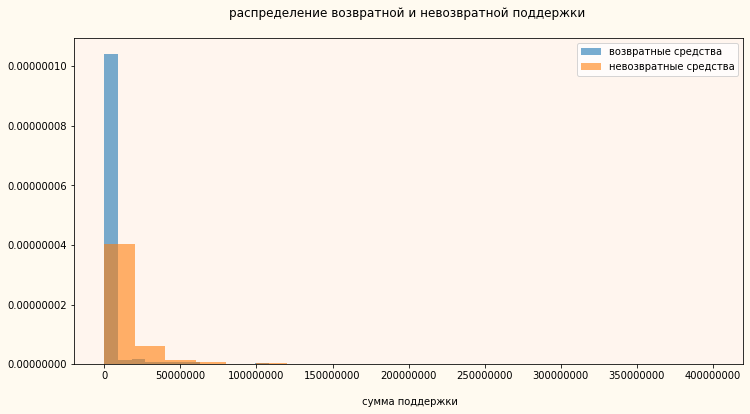

In [83]:
# Строю гистограмму
fig, ax = plt.subplots()
plt.hist(data['refundable_support'], bins = 20, alpha=0.6, label = 'возвратные средства', density = True)
plt.hist(data['nonrefundable_support'], bins = 20, alpha=0.6, label = 'невозвратные средства', density = True)
plt.legend(loc = 'upper right')
plt.xlabel('\n сумма поддержки')
fig.set_figwidth(12)    
fig.set_figheight(6)    
plt.title('распределение возвратной и невозвратной поддержки \n')
plt.ticklabel_format(useOffset=False, style='plain')
fig.set_facecolor('floralwhite')
ax.set_facecolor('seashell')
plt.show()

<div class="alert-warning" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ⚠️</b>

Здесь можно добавить прозрачности на гистограммы, чтобы было видно распределение обоих параметров. </div>

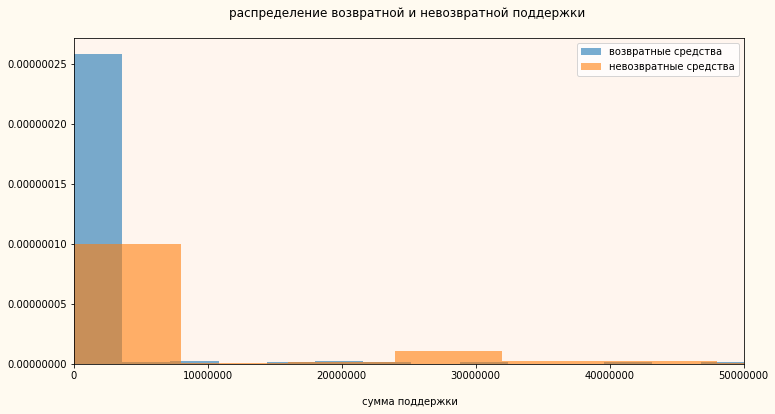

In [84]:
# Строю гистограмму
fig, ax = plt.subplots()
plt.hist(data['refundable_support'], bins = 50, alpha=0.6, label = 'возвратные средства', density = True)
plt.hist(data['nonrefundable_support'], bins = 50, alpha=0.6, label = 'невозвратные средства', density = True)
plt.legend(loc = 'upper right')
plt.xlabel('\n сумма поддержки')
plt.title('распределение возвратной и невозвратной поддержки \n')
plt.ticklabel_format(useOffset=False, style='plain')
plt.xlim(0, 50000000)
fig.set_figwidth(12)    
fig.set_figheight(6)    
fig.set_facecolor('floralwhite')
ax.set_facecolor('seashell')
plt.show()


Из первой гистограммы видно, что у нас есть выборосы - какие-то фильмы, которые получили на порядок больше средств, чем остальные.
Из второй гистограммы видно, что невозвратная поддержка часто оказывается на большую сумму (немного неожиданно).

Посмотрим на выбросы в наблюдениях.

In [85]:
# квантили
print(data.query('refundable_support>0')['refundable_support'].quantile([0.0012, 0.01, .5, .99, .9988]).apply('{:,.0f}'.format))
print()
print((
    data
    .query('nonrefundable_support>0')['nonrefundable_support'].quantile([0.0012, 0.01, .5, .99, .9988]).apply('{:,.0f}'.format))
)

0.0012      3,694,400
0.0100      5,000,000
0.5000     25,000,000
0.9900    147,200,000
0.9988    176,112,000
Name: refundable_support, dtype: object

0.0012      3,760,800
0.0100      5,051,000
0.5000     30,000,000
0.9900    300,000,000
0.9988    400,000,000
Name: nonrefundable_support, dtype: object


Среди тех, кто получал невозвратную помощь, медиана в помощи была в 30 млн.р., но 0.12% фильмов получили невозвратную помощь более чем в 10 раз больше.

Посмотрим, что это за лидеры по невозвратной поддержке.

In [86]:
data.query('nonrefundable_support>=400000000')

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,year,main_director,main_genres,fraction
4973,Движение вверх,111011817,2017-12-21 00:12:00,Художественный,"ооо ""студия ""тритэ"" никиты михалкова""",Россия,А.Мегердичев,"Л.Верещагин, А.Златопольский, Н.Михалков, ООО ...",«6+» - для детей старше 6 лет,0.0,400000000.0,590192191.0,Фонд кино,7.5,"спорт,драма",2.779686e+09,2017,А.Мегердичев,спорт,0.677745
6723,Союз спасения,111022019,2019-12-26 00:12:00,Художественный,"зао ""дирекция кино""",Россия,А.Кравчук,"А.Максимов, К.Эрнст",«12+» - для детей старше 12 лет,100000000.0,400000000.0,980000000.0,Фонд кино,6.0,"история,биография,драма",7.177032e+08,2019,А.Кравчук,история,0.510204


Посмотрим на возвратную и невозвратную помощь по годам

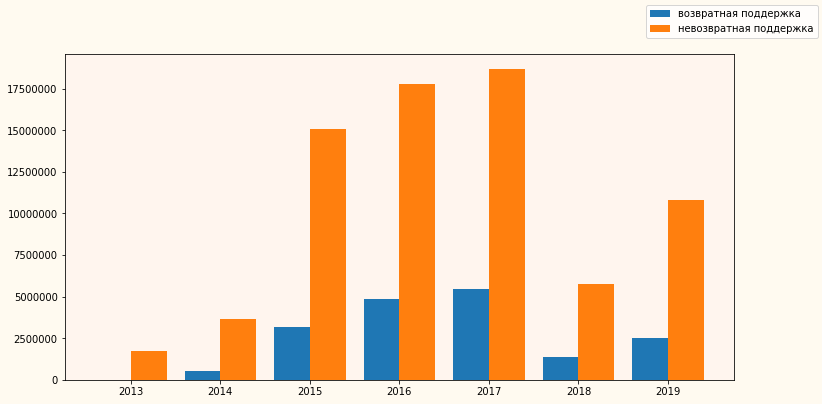

In [87]:
# столбчатая диаграмма
fig, ax = plt.subplots()
x1 = data.query('refundable_support.notna()').groupby('year')['refundable_support'].mean().index - 0.2
x2 = data.query('nonrefundable_support.notna()').groupby('year')['nonrefundable_support'].mean().index+0.2
y1 = data.query('refundable_support.notna()').groupby('year')['refundable_support'].mean()
y2 = data.query('nonrefundable_support.notna()').groupby('year')['nonrefundable_support'].mean()


ax.bar(x1, y1, width = 0.4, label = 'возвратная поддержка')
ax.bar(x2, y2, width = 0.4, label = 'невозвратная поддержка')
fig.legend(loc = 'upper right')
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_facecolor('seashell')
fig.set_figwidth(12)    
fig.set_figheight(6)    
fig.set_facecolor('floralwhite')

plt.show()

Посмотрю теперь на общие траты государства по годам.

Из диаграммы мы видимо, что во-первых, невозвратная поддержка всегда превышала возвратную. Во-вторых, есть нелинейная динамика - был существенный рост финансовой поддержки в 2015-2017 годы. 

In [88]:
# общие траты по годам
data['total_support'] = data['refundable_support']+data['nonrefundable_support']
data.groupby('year')['total_support'].sum().apply('{:,.0f}'.format)

year
2010                0
2011                0
2012                0
2013      134,347,945
2014      572,002,299
2015    3,641,541,459
2016    4,303,155,482
2017    3,183,971,662
2018    3,446,969,465
2019    4,349,000,000
Name: total_support, dtype: object

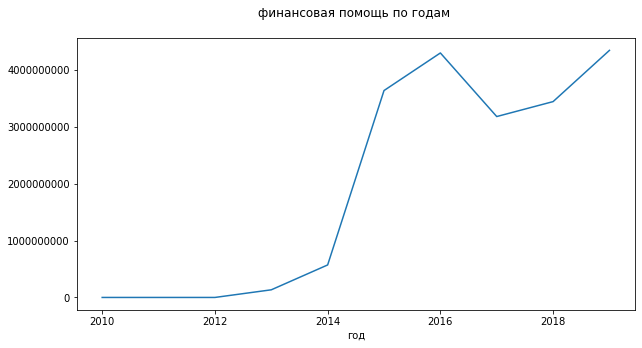

In [89]:
# график
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
ax.plot(data.groupby('year')['total_support'].sum())
ax.ticklabel_format(useOffset=False, style='plain')
plt.xlabel('год')
plt.title('финансовая помощь по годам \n')
plt.show()

Виден резкий рост расходов на кино, начиная с 2014 года. Похоже, что начиная с 2014 года у государства появилось желание вкладывать деньги в российское кино.

<div class="alert-success" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ✔️</b>

Или данных за период до 2014 года мало.</div>

Теперь посмотрим, как связана финансовая поддерка с успешностью фильма (сборами и рейтингом). Посмотрим как свяазана финансовая поддержка с бюджетом, сборами и рейтингом фильма.

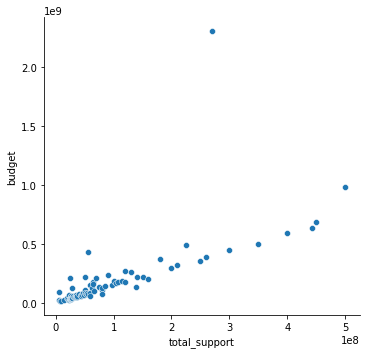

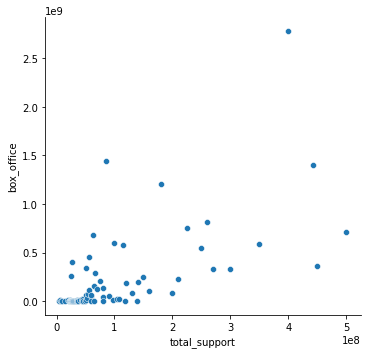

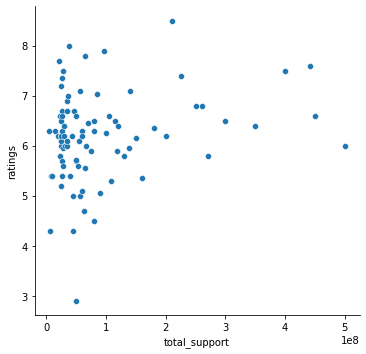

In [90]:
# строим scatter plot для медианных значений
support_pivot_area = (data
                      .query('budget.notna() and box_office.notna()')
                      .pivot_table(index = 'total_support', values =(['budget', 'box_office', 'ratings']), aggfunc = 'median')
                     )
support_pivot_area = support_pivot_area.reset_index()
for row in ['budget', 'box_office', 'ratings']:
    sns.relplot(data = support_pivot_area, x = 'total_support', y = row, kind = 'scatter')

На диаграммах видно, что финансовая помощь очень сильно связана с медианным бюджетом, видна практически линейная зависимость, но зависимость между помощью и сборами либо же рейтингом уже не так очевидна.

In [91]:
# считаем корреляция
data['total_support'].corr(data['budget'])

0.7162844009063769

Действительно очень сильная корреляция.

Оценим теперь эту взаимосвязь статистически.

Сравним теперь российские фильмы с и без финансовой помощи. Для начала вспомним, сколько у нас таких наблюдений.

In [92]:
# считаем наблюдения
display(data.query('total_support==0')['type'].count())
display(data.query('total_support==0')['box_office'].count())
display(data.query('total_support>0')['type'].count())
display(data.query('total_support>0')['box_office'].count())

1219

396

327

314

У нас есть данные о 1219 российских фильмах, не получавших деньги от государства, из которых у 396 фильмов мы знаем данные о сборах. С другой стороны, у нас есть данные о 327 фильмах, получавших поддержку у государства, из которых у 314 мы знаем сборы.

Сравним средние рейтинги и сборы у этих категорий.

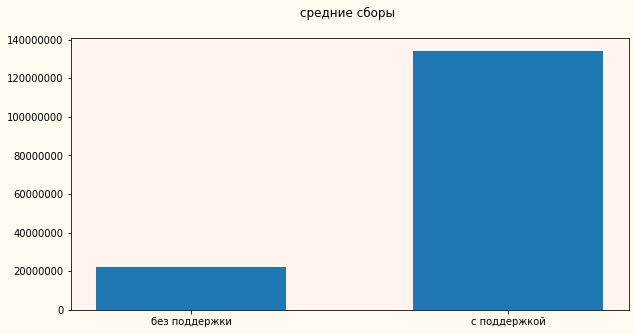

In [93]:
# столбчатая диаграмма
fig, ax = plt.subplots()
x = ['без поддержки','с поддержкой']
y = (
    [data
     .query('total_support==0 and box_office.notna()')['box_office']
     .mean(),data.query('total_support>0 and box_office.notna()')['box_office'].mean()]
)


ax.ticklabel_format(useOffset=False, style='plain')
ax.bar(x, y, width = 0.6)

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(10)   
fig.set_figheight(5)   
plt.title('средние сборы \n')
plt.show()

Действительно, у российских фильмов с поддержкой от государства средние сборы в разы больше.

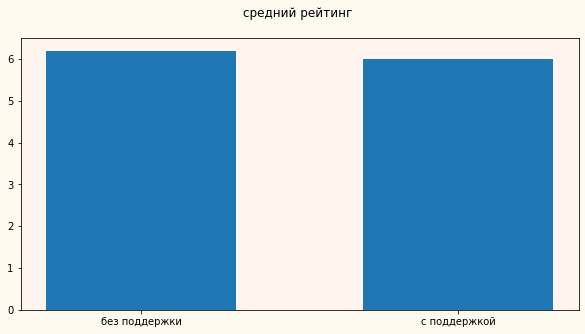

In [94]:
# столбчатая диаграмма
fig, ax = plt.subplots()
x = ['без поддержки','с поддержкой']
y = (
    [data
     .query('total_support==0')['ratings']
     .mean(),data.query('total_support>0')['ratings'].mean()]
)


ax.ticklabel_format(useOffset=False, style='plain')
ax.bar(x, y, width = 0.6)

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(10)   
fig.set_figheight(5)   
plt.title('средний рейтинг \n')
plt.show()


А вот какой-то заметной разницы в среднем рейинге не видно.

Проверим теперь эти выводы статистически.

Вначале оценим линейную регрессия сборов на размер финансовой помощи, влючая как фильмы, которые её получают, так и фильмы, получающие 0.

In [95]:
# оцениваю линейную регрессию
d = data.query('box_office.notna() and total_support.notna()')
x = (d[['total_support']].astype(float))
y = d['box_office'].astype(float)
x2 = sm.add_constant(x)
reg = sm.OLS(y,x2).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:             box_office   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     248.8
Date:                Thu, 09 Mar 2023   Prob (F-statistic):           2.99e-48
Time:                        08:02:38   Log-Likelihood:                -14596.
No. Observations:                 710   AIC:                         2.920e+04
Df Residuals:                     708   BIC:                         2.921e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.249e+07   8.58e+06      1.456

Регрессия показала, что действительно финансовая помощь очень сильно влияет на сборы фильма (на каждый рубль помощи сборы в среднем растут на 2.19 рублей). Стоит ещё отметить, что фильмы с большой помощью пользуются и другими привилегиями административного ресурса, которые не учитываются в модели - например, рекламой на федеральных каналах, а реклама увеличивает сборы. 

Посмотрю, есть ли разница между возвратной и невозвратной помощью.

In [96]:
# оцениваю линейную регрессию
d = data.query('box_office.notna() and total_support.notna()')
x = (d[['refundable_support','nonrefundable_support']].astype(float))
y = d['box_office'].astype(float)
x2 = sm.add_constant(x)
reg = sm.OLS(y,x2).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:             box_office   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     124.3
Date:                Thu, 09 Mar 2023   Prob (F-statistic):           5.34e-47
Time:                        08:02:38   Log-Likelihood:                -14596.
No. Observations:                 710   AIC:                         2.920e+04
Df Residuals:                     707   BIC:                         2.921e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   1.26e+

Большой разницы между возвратной и невозвратной помощью - обе переменные значимо увеличивают сборы фильма и на каждый рубль, инвестированный государством, сборы вырастают чуть больше, чем на два рубля.

Теперь посмотрим на влияние на рейтинг. Я сравниваю все российские фильмы после 2013 года - как получающие, так и не получающие помощь от государства.

In [97]:
# оцениваю линейную регрессию
d = data.query('total_support.notna() and ratings.notna()')
x = (d[['refundable_support','nonrefundable_support']].astype(float))
y = d['ratings'].astype(float)
x2 = sm.add_constant(x)
reg = sm.OLS(y,x2).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                ratings   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9881
Date:                Thu, 09 Mar 2023   Prob (F-statistic):              0.373
Time:                        08:02:38   Log-Likelihood:                -1869.9
No. Observations:                1156   AIC:                             3746.
Df Residuals:                    1153   BIC:                             3761.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     6.13

Интересно, что хоть на успешность фильма финансовая помощь влияет, а вот на качестве фильма она практически никак не отображается. 
Посмотрим на такую же регрессию, не разделяя на типы помощи.

In [98]:
# оцениваю линейную регрессию
d = data.query('total_support.notna() and ratings.notna()')
x = (d[['total_support']].astype(float))
y = d['ratings'].astype(float)
x2 = sm.add_constant(x)
reg = sm.OLS(y,x2).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                ratings   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.08896
Date:                Thu, 09 Mar 2023   Prob (F-statistic):              0.766
Time:                        08:02:38   Log-Likelihood:                -1870.9
No. Observations:                1156   AIC:                             3746.
Df Residuals:                    1154   BIC:                             3756.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             6.1346      0.038    159.981

Ни деньги ни финансовая помощь не могут значимо улучшить рейтинг российского кино.

В заключение, хочется дать какие-то реккомендации для министерства культуры, на какие жанры и режиссеров стоит обратить внимание, если хочется поддержать именно хорошее кино, которое нравится как зрителям, так и критикам и которое получает высокие рейтинги.

Составлю топ жанров, режиссёров и возрастных категорий по рейтингу.

In [99]:
# группирую данные
data.groupby('ratings')['main_genres'].agg(pd.Series.mode).to_frame().sort_index(ascending = False).head(10)

,main_genres
ratings,
9.1,драма
9.0,мультфильм
8.9,драма
8.8,мультфильм
8.7,"[боевик, фантастика]"
8.6,"[боевик, триллер, фэнтези]"
8.5,мультфильм
8.4,мелодрама
8.3,документальный


А теперь посмотрим в какие жанры в основном сейчас вкладывают деньги.

In [100]:
# группирую
data.groupby('total_support')['main_genres'].agg(pd.Series.mode).to_frame().sort_index(ascending = False).head(10)

,main_genres
total_support,
500000000.0,история
450000000.0,драма
442104482.0,драма
400000000.0,спорт
350000000.0,история
300000000.0,"[детектив, драма, фэнтези]"
270000000.0,приключения
260000000.0,драма
250000000.0,"[приключения, фантастика, фэнтези]"


Заметно, что государство много инвестирует в исторические фильмы, которые вообще не фигурируют в топе рейтинга. 

Теперь посмотрим на режиссеров фильмов с высоким рейтингом.

In [101]:
# группирую данные
data.loc[data['production_country'].str.contains('Россия')].groupby('ratings')['main_director'].agg(pd.Series.mode).to_frame().sort_index(ascending = False).head(10)

,main_director
ratings,
9.0,М.Мошкова
8.8,В.Панков
8.7,"[Д.Червяцов, Р.Гарифуллин]"
8.6,А.Истратов
8.5,"[Анна Соловьева, Артем Лукичев, В.Тодоровский,..."
8.4,"[А.Стреляная, А.Учитель, Н.Тамаров, С.Сенцов]"
8.3,"[В.Ефремов, В.Тимощенко, Е.Чернова, Н.Кудряшов..."
8.2,"[А.Кравчук, А.Сухарев, А.Шелехов (псевдоним Ал..."
8.1,"[А.Аманшаев, А.Атанесян, А.Голубовский, А.Дени..."


И наконец сравним возрастные ограничения у фильмов с высоким рейтингом и у тех фильмов, которые финансирует государство.

In [102]:
data

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,...,budget,financing_source,ratings,genres,box_office,year,main_director,main_genres,fraction,total_support
0,Открытый простор,221048915,2015-11-27 00:12:00,Художественный,"тачстоун пикчерз, кобальт пикчерз, бикон пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,...,NaN,NaN,7.2,"боевик,драма,мелодрама",NaN,2015,Кевин Костнер,боевик,NaN,NaN
1,Особо важное задание,111013716,2016-09-13 00:12:00,Художественный,"киностудия ""мосфильм""",СССР,Е.Матвеев,unknown,«6+» - для детей старше 6 лет,NaN,...,NaN,NaN,6.6,"драма,военный",NaN,2016,Е.Матвеев,драма,NaN,NaN
2,Особо опасен,221038416,2016-10-10 00:12:00,Художественный,"юниверсал пикчерз, кикстарт продакшнз, марк пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,...,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN,2016,Тимур Бекмамбетов,фантастика,NaN,NaN
3,Остановился поезд,111013816,2016-09-13 00:12:00,Художественный,"киностудия ""мосфильм""",СССР,В.Абдрашитов,unknown,«6+» - для детей старше 6 лет,NaN,...,NaN,NaN,7.7,драма,NaN,2016,В.Абдрашитов,драма,NaN,NaN
4,Любовь и голуби,111007013,2013-10-18 00:12:00,Художественный,"киностудия ""мосфильм""",СССР,В.Меньшов,unknown,«12+» - для детей старше 12 лет,NaN,...,NaN,NaN,8.3,"мелодрама,комедия",2700.0,2013,В.Меньшов,мелодрама,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6739,Сад художника: Американский импрессионизм,126008019,2019-12-23 00:12:00,Прочие,севен артс продакшнз,Великобритания,Фил Грабски,Фил Грабски,«12+» - для детей старше 12 лет,NaN,...,NaN,NaN,NaN,unknown,NaN,2019,Фил Грабски,unknown,NaN,NaN
6740,Звериная ярость,121037819,2019-12-24 00:12:00,Художественный,"дэниел гродник продакшнз, вандерфилм медиа кор...",США,Ник Пауэлл,"Джефф Боулер, Дэниэл Гродник, Луильо Руис, Брэ...",«16+» - для детей старше 16 лет,NaN,...,NaN,NaN,5.4,"боевик,триллер",NaN,2019,Ник Пауэлл,боевик,NaN,NaN
6741,Щенячий патруль: Скорей спешим на помощь!,124010819,2019-12-28 00:12:00,Художественный,"никелодеон анимейшн студиос, спин мастер",США - Канада,Чарльз Е.Бастьен,Дженнифер Додж,«0+» - для любой зрительской аудитории,NaN,...,NaN,NaN,NaN,unknown,NaN,2019,Чарльз Е.Бастьен,unknown,NaN,NaN
6742,"Машины песенки. Серия ""Испанские мотивы""",124010619,2019-12-30 00:12:00,Анимационный,"анимаккорд лтд., ооо студия ""анимаккорд""","Республика Кипр, Россия",А.Беляев,Д.Ловейко,«0+» - для любой зрительской аудитории,0.0,...,NaN,NaN,NaN,unknown,NaN,2019,А.Беляев,unknown,NaN,0.0


In [103]:
# группирую данные
data.groupby('ratings')['age_restriction'].agg(pd.Series.mode).to_frame().sort_index(ascending = False).head(10)

,age_restriction
ratings,
9.1,«16+» - для детей старше 16 лет
9.0,«0+» - для любой зрительской аудитории
8.9,«16+» - для детей старше 16 лет
8.8,«0+» - для любой зрительской аудитории
8.7,«0+» - для любой зрительской аудитории
8.6,"[«12+» - для детей старше 12 лет, «18+» - запр..."
8.5,«6+» - для детей старше 6 лет
8.4,«16+» - для детей старше 16 лет
8.3,«12+» - для детей старше 12 лет


In [104]:
data.groupby('total_support')['age_restriction'].agg(pd.Series.mode).to_frame().sort_index(ascending = False).head(10)

,age_restriction
total_support,
500000000.0,«12+» - для детей старше 12 лет
450000000.0,«16+» - для детей старше 16 лет
442104482.0,«6+» - для детей старше 6 лет
400000000.0,«6+» - для детей старше 6 лет
350000000.0,«12+» - для детей старше 12 лет
300000000.0,«16+» - для детей старше 16 лет
270000000.0,«6+» - для детей старше 6 лет
260000000.0,«12+» - для детей старше 12 лет
250000000.0,«6+» - для детей старше 6 лет


Среди фильмов с высоким рейтингом чаще встречаются фильмы 0+, но они редко финансируются государством.

<div class="alert-warning" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ⚠️</b>
    
У тебя получилось хорошее исследование фильмов с господдержкой и выводы интересные.
    
Для полноты картины целесообразно было бы сравнить российские фильмы, получившие господдержку с российскими фильмами без нее.

Для того чтобы понять, насколько эффективна господдержка, давай попробуем выделить в два датафрейма российские фильмы с господдержкой и без нее и сравнить их по средним рейтингам и сборам.</div>

<div class="alert-success" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера V2 ✔️</b>

Отлично! Возможно сборы больше так как часть средств идет на раскрутку. И в то же время, получается что на качество фильмов господдержка не влияет, раз зрители оценивают их так же.</div>

# Шаг 5. Напишите общий вывод

В данном проекте я изучила данные из двух источников - из Кинопоиска и от Министерства Культуры. 

Я объединила данные из этих источников в один датасет. Я поменяла типы у даты и у рейтинга и унифицировала вид рейтинга.
В данных были пропуски - в некоторых переменных пропусков было очень много - например в данных о финансовой поддержке, скорее всего потому, что данные были доступны лишь по тем фильмам, которую поддержку получили и лишь в определённых годах. В некоторых переменных пропусков было очень мало - где было возможно я заполнила пропуски руками, остальные такие немногие наблюдения удалила. 
В данных про рейтинг фильма пропусков было не очень много, но при этом и не очень мало и такие данные не хотелось терять. Я волспользовалась алгоритмом knn и заполнила пропуски средними из схожих наблюдений по уровню сборов. 
Последним этапом предобработки данных я обнаружила, что есть российские фильмы, вышедшие после 2013 года (дата начала данных о финансовой помощи) с пропусками в переменных о помощи. Это означало, что они её не получали и я заменила пропуски нулями.

Я создала новые переменные с годом выхода фильма, выделила главного режиссера и жанр и посчитала долю, которую занимала финансовая поддержка в бюджете фильма. 

Ислледование динамики проката показало, что она была очень нелинейной и вслед за годами с большим колличеством вышедших фильмов бывали года с очень небольшим прокатом - особенно это заметно в 2011 и в 2017. 

При этом анализ сборов в кинотеатрах показал экспоненциальный рост сборов в районе 2014/2015 годов с максимальным значением сборов в 2017 году. 

При этом сравнение среднего и медианы показало, что распределение сборов сильно смещённое - медиана и среднее отличались в разы. Поэтому в случаях, где это было возможно, я использовала медианное значение в дальнейшем исследовании.

Далее я рассмотрела влияние возрастного ограничения на сборы. Если в ранние годы с небольшими сборами, наибольшие медианные сборы приходились на фильмы 0+, то в годы с большими сборами наибольшее значение было у фильмов 6+. Дальнейший статистический анализ показал, что эти различия тем не менее не являются статистически значимыми. 

В заключительной части проекта я исследовала влияния финансовой помощи на успешность и рейтинг российских фильмов. Анализ показал, что доля фильмов, получающих финансовую поддержку государства менялась нелинейно и достигла максимума в 2015 году, когда более 40% выходивших фильмов получили государственную денежную поддержку. При этом распределение возвратной и невозвратной помощи показало, что невозвратная помощь чаще давалась в более крупных размерах. Общие траты государства на финансовую поддержку российских фильмов начинает резко расти после 2014 года. 
Финансовая поддержка очень сильно коррелирует с бюджетом фильма и оказывает значимое влияние на сборы фильмов - на 1 рубль помощи сборы растут в среднем на 2.16 рублей. Но к данному выводу надо относиться с осторожностью, потому что финансовая помощь так же скоррелирована с доступом к рекламе и продвижению фильмов на федеральных каналах, что сильно связано с кассовым успехом фильма, но учесть в регрессии мы это не можем.
Тем не менее ни бюджет фильма ни финансовая поддержка не оказывают значимого влияния на рейтинг фильма. Видимо для улучшения качества российского кинематографа нужно что-то помимо денег.

Для повышения художественной эффективности финансовой поддержки можно порекомендовать меньше вкладывать деньги в исторические фильмы и возможно рассмотреть категорию фильмов 0+, у которых меньше сборы, но более высокие рейтинги. 

<div class="alert-success" style="padding: 20px; border-radius: 10px">
<b>Комментарий ревьюера ✔️</b>

Очень хороший общий вывод, отражающий все основные результаты исследования. 
    
Можешь добавить какие-то рекомендации заказчику для повышения эффективности господдержки (жанры, возрастные категории, режиссеры) или что-то еще?</div>

<div style="border:solid steelblue 3px; padding: 20px; border-radius: 10px">
    
<b>Общий комментарий ревьюера:</b>

У тебя получилась очень сильная работа, ты отлично справилась с обработкой данных и исследовательским анализом.
    
Также мне понравилось твое умение строить графики и правильно их комментировать.
    
У меня только одно критическое замечание - по исследованию сборов фильмов в разрезе возрастных категорий. 
    
Постарайся также отработать "желтые" комментарии и написать промежуточные выводы по разделам работы.
    
Буду ждать твой доработанный проект. ⌛️</div>

<div style="border:solid steelblue 3px; padding: 20px; border-radius: 10px">
    
<b>Общий комментарий ревьюера V2</b>

Спасибо, что доработала проект! Критических замечаний больше нет, получилась отличная работа, ты здорово владеешь материалом. Уверен что ты будещь продолжать показвать отличные результаты в будущем!
    
Успехов в дальнейшем обучении! 🏆
    
</div>